In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [67]:
# Carregando os dados
obitos = pd.read_csv("C:\\Users\\maste\\Downloads\\Python-Datasus-master\\Python-Datasus-master\\Obitos-Capitulo-CID10-2015-2020.csv", sep=';', index_col=0)
obito2020 = pd.read_csv("C:\\Users\\maste\\Downloads\\Python-Datasus-master\\Python-Datasus-master\\Obitos-Capitulo-CID10-2020.csv", sep=';')

In [69]:
# Gerando dicionário com descrições dos Capítulos
capitulos = {}
for linha in obito2020['Capítulo CID-10']:
    pos = linha.find('.')
    chave = linha[0:pos]
    valor = linha[pos + 1:]
    capitulos[chave] = valor.lstrip()
capitulos['Total'] = 'Nacional'

In [71]:
# Renomeando os capítulos no DataFrame obitos
alterar_cap = dict(zip(obitos.columns, capitulos.keys()))
obitos = obitos.rename(columns=alterar_cap)

In [73]:
# Transposição do DataFrame para facilitar a visualização
obitos = obitos.T

In [75]:
# Estatísticas descritivas para entender a distribuição dos dados
print(obitos.describe())

Ano do Óbito          2015          2016          2017          2018  \
count         2.000000e+01  2.000000e+01  2.000000e+01  2.000000e+01   
mean          1.264175e+05  1.309774e+05  1.312663e+05  1.316719e+05   
std           2.820778e+05  2.922092e+05  2.927856e+05  2.935558e+05   
min           2.100000e+01  2.000000e+01  1.900000e+01  2.100000e+01   
25%           6.225750e+03  6.627000e+03  6.491500e+03  6.519000e+03   
50%           3.563500e+04  3.811850e+04  3.962800e+04  4.223150e+04   
75%           9.456150e+04  9.752150e+04  9.865150e+04  9.872725e+04   
max           1.264175e+06  1.309774e+06  1.312663e+06  1.316719e+06   

Ano do Óbito          2019          2020  
count         2.000000e+01  2.000000e+01  
mean          1.349801e+05  1.552739e+05  
std           3.006927e+05  3.438574e+05  
min           2.300000e+01  2.500000e+01  
25%           7.131000e+03  6.766750e+03  
50%           4.640050e+04  4.493750e+04  
75%           9.831375e+04  1.458800e+05  
max    

<Figure size 1000x600 with 0 Axes>

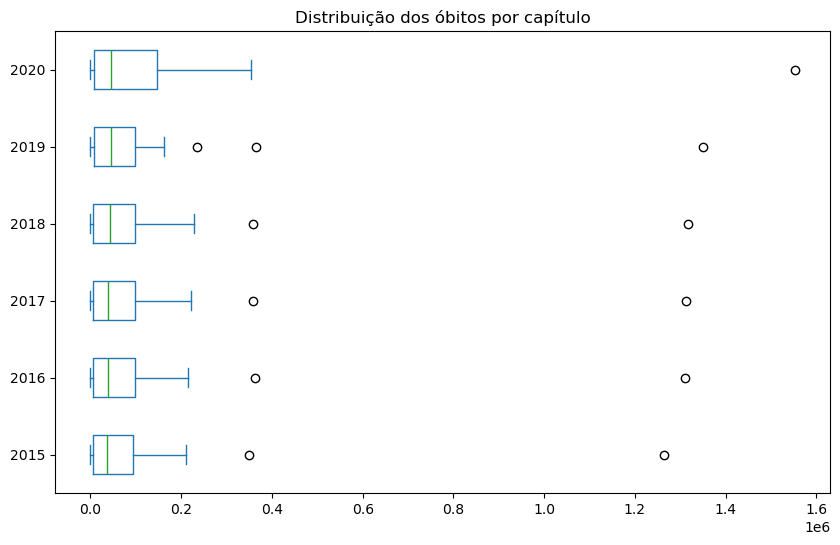

In [77]:
# Gráfico de boxplot para detectar outliers
plt.figure(figsize=(10, 6))
obitos.plot(kind='box', vert=False)
plt.title('Distribuição dos óbitos por capítulo')
plt.show()

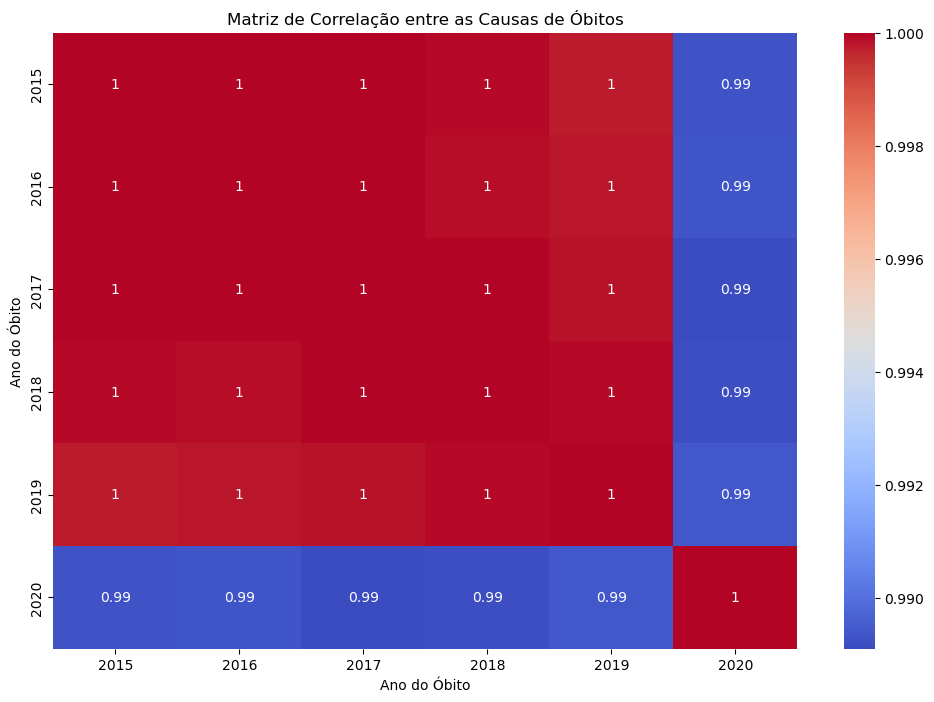

In [79]:
# Cálculo da correlação entre as variáveis
correlation_matrix = obitos.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Matriz de Correlação entre as Causas de Óbitos')
plt.show()

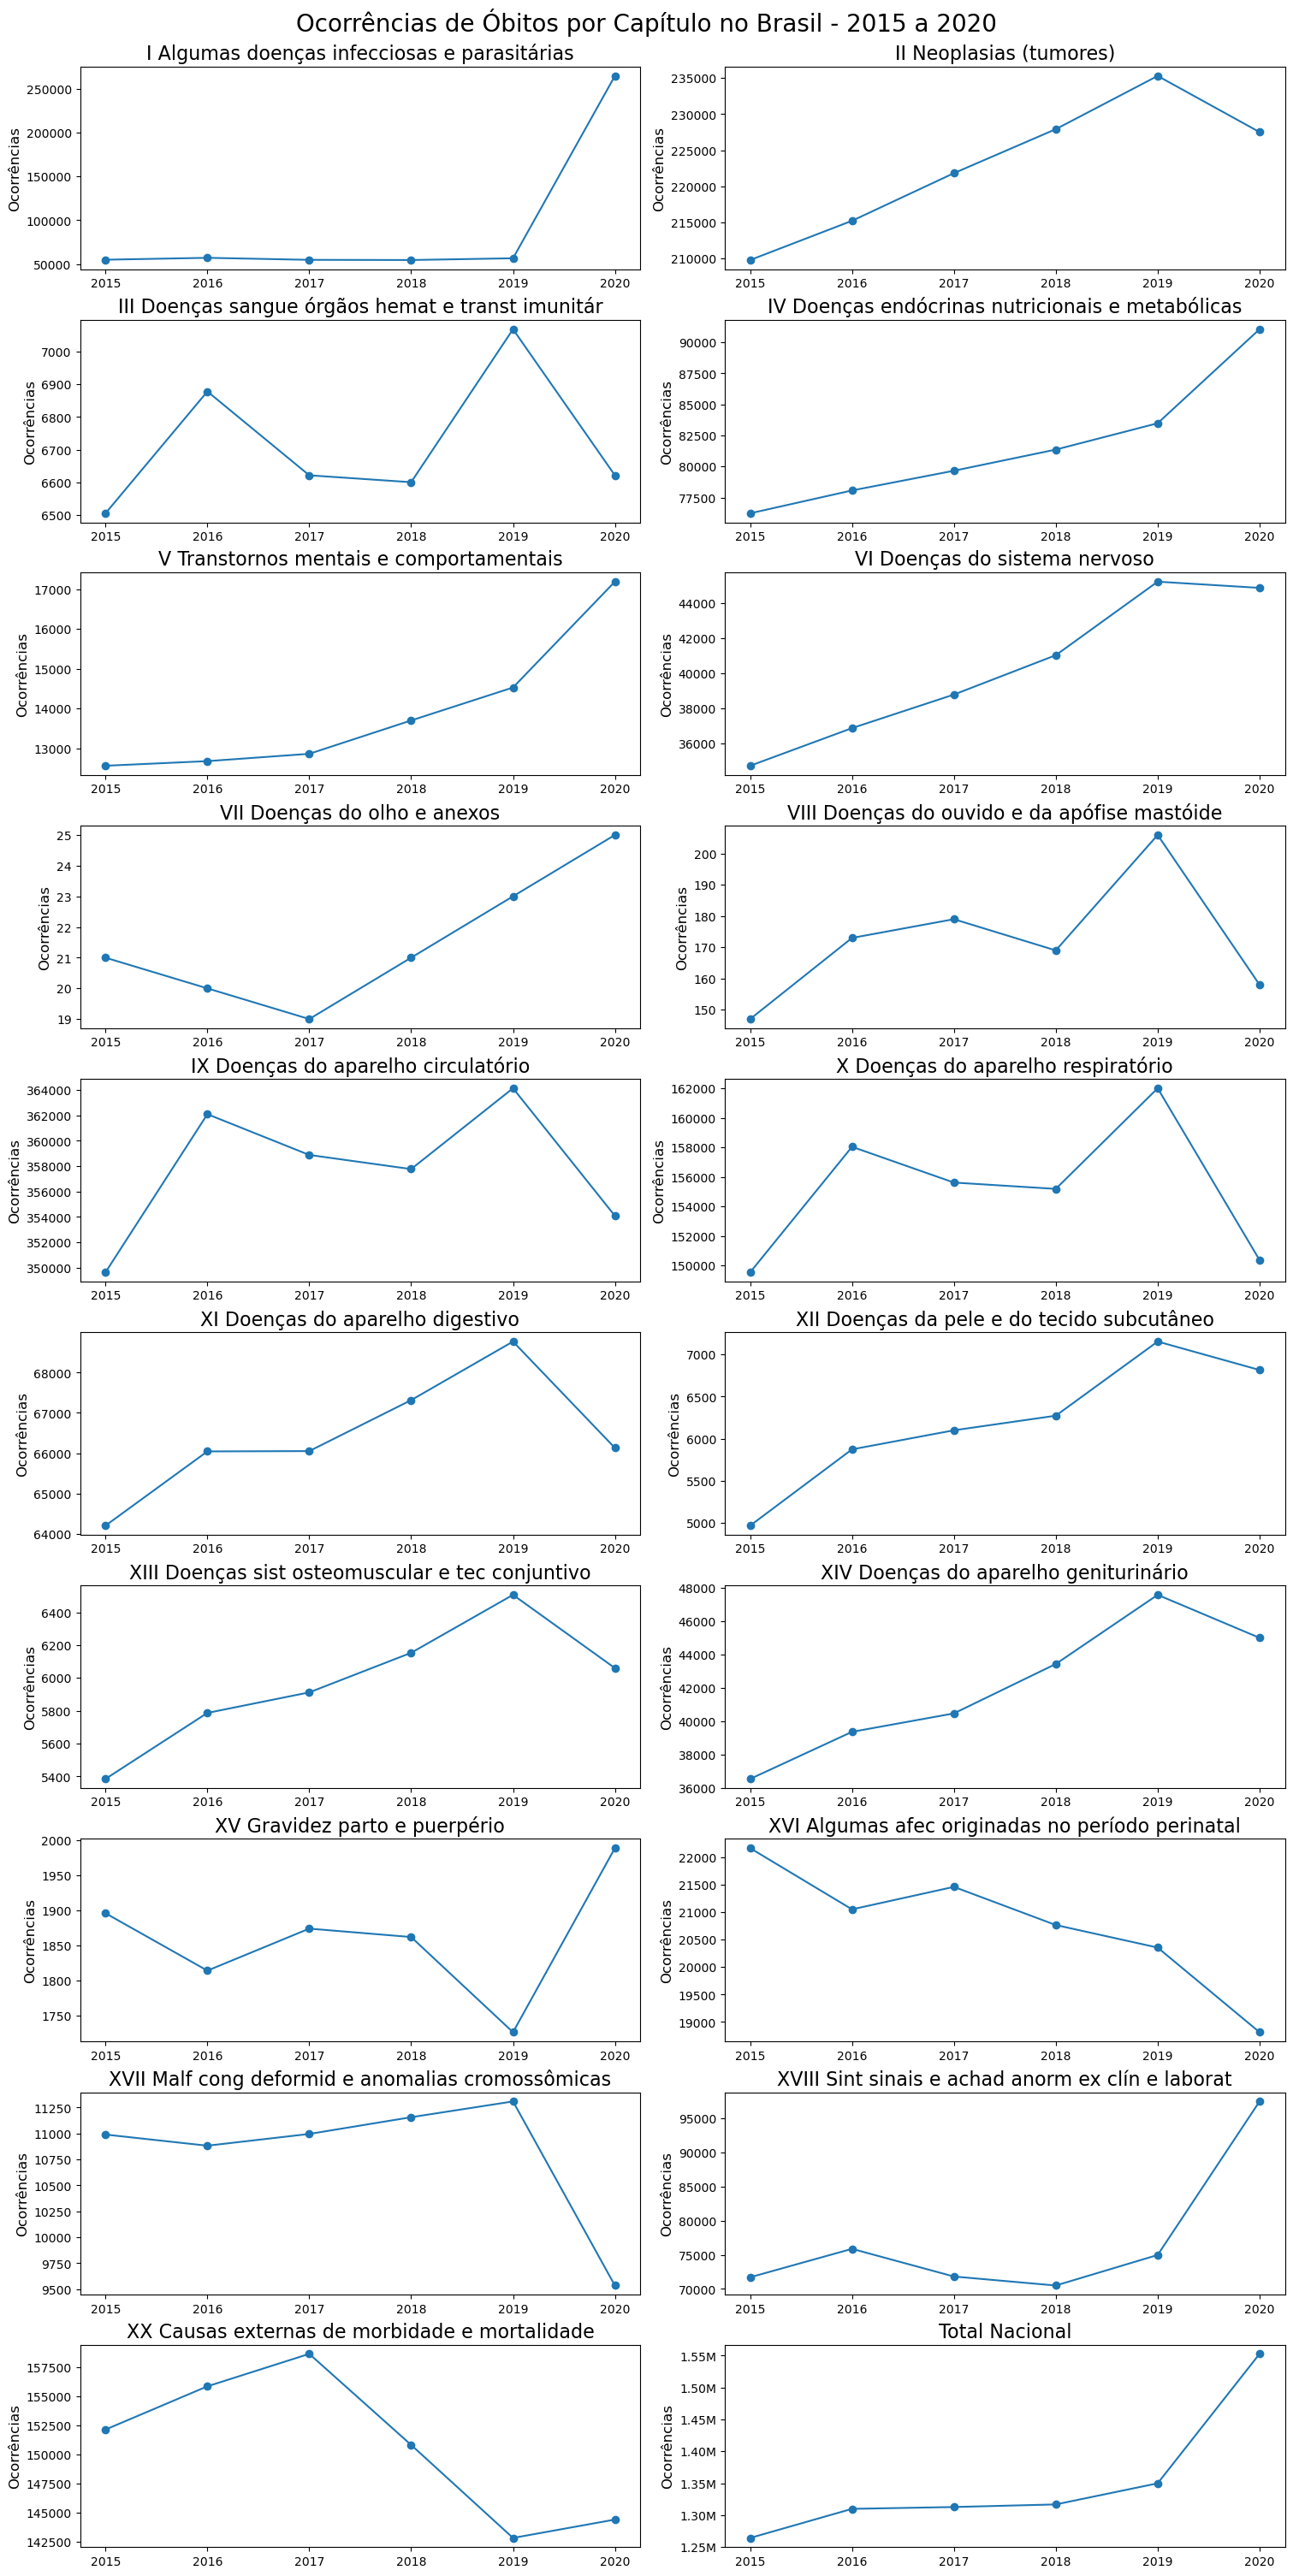

In [81]:
# Visualizações de séries temporais (ocorrências de óbitos por ano)
anos = list(obitos.columns)
plt.rc('figure', figsize=(15, 30))

fig, axs = plt.subplots(nrows=10, ncols=2, constrained_layout=True)
idx1 = 0
idx2 = 0
for index, valores in obitos.iterrows():
    axs[idx1, idx2].plot(anos, valores, marker='o')
    axs[idx1, idx2].set_ylabel('Ocorrências', {'fontsize': 12})
    axs[idx1, idx2].set_title(index + ' ' + capitulos[index], {'fontsize': 16})
    if(index == 'Total'):
        axs[idx1, idx2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:1.2f}M'.format(x * 1e-6)))
    if(idx2 == 0):
        idx2 = 1
    else:
        idx2 = 0
        idx1 += 1
fig.suptitle('Ocorrências de Óbitos por Capítulo no Brasil - 2015 a 2020', fontsize=20)
plt.show()

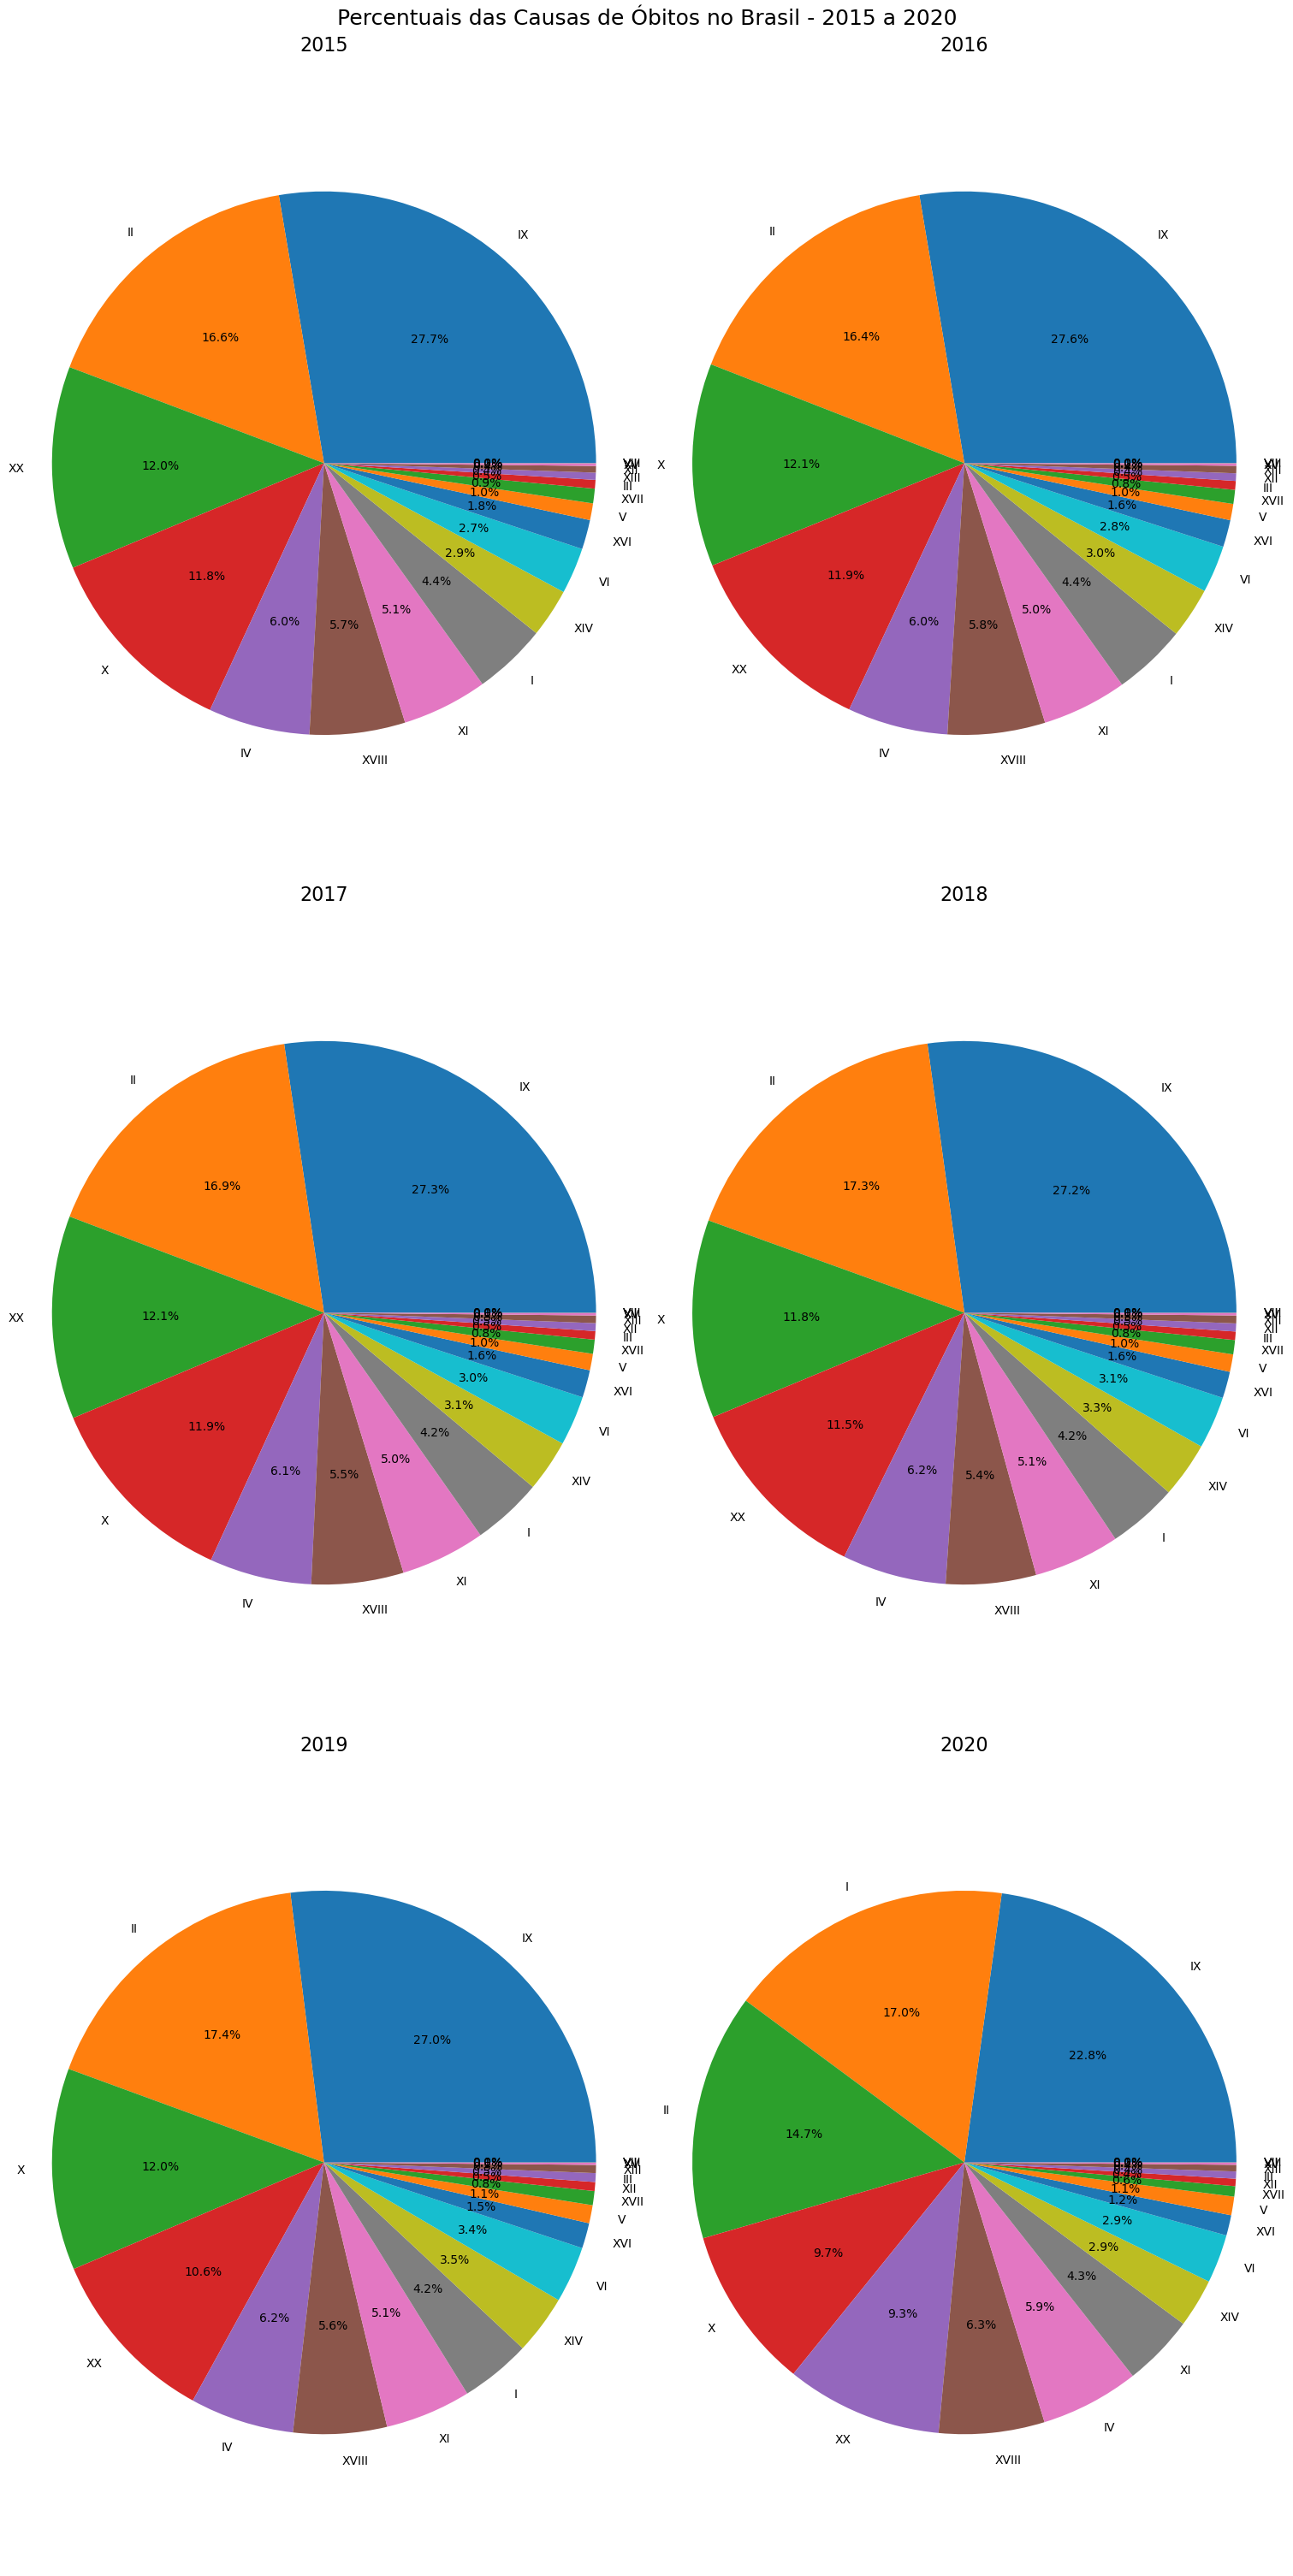

In [85]:
# Gráficos de pizza (percentuais das causas de óbitos por ano)
fig, axs = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
idx1 = 0
idx2 = 0
for ano in tuple(obitos.columns):
    dfano = pd.DataFrame(list(obitos[ano].values[:-1]), list(obitos.index[:-1]))
    dfano.sort_values(by=0, ascending=False, inplace=True)
    labels = tuple(dfano.index)
    sizes = list(dfano[0].values)
    axs[idx1, idx2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0)
    axs[idx1, idx2].set_title(str(ano), {'fontsize': 16})
    axs[idx1, idx2].axis('equal')
    if(idx2 == 0):
        idx2 = 1
    else:
        idx2 = 0
        idx1 += 1
fig.suptitle('Percentuais das Causas de Óbitos no Brasil - 2015 a 2020', fontsize=18)
plt.show()

In [87]:
# Carregando dados de nascimentos
nascimentos = pd.read_csv("C:\\Users\\maste\\Downloads\\Python-Datasus-master\\Python-Datasus-master\\Nascimentos-2015-2020.csv", sep=';', index_col=0)
nascimentos = nascimentos.T

In [89]:
# Calculando o total de nascimentos e óbitos por ano
total_nasc = list(nascimentos.values[0])
total_obt = list(obitos.values[len(obitos)-1])

anos = list(nascimentos.columns)

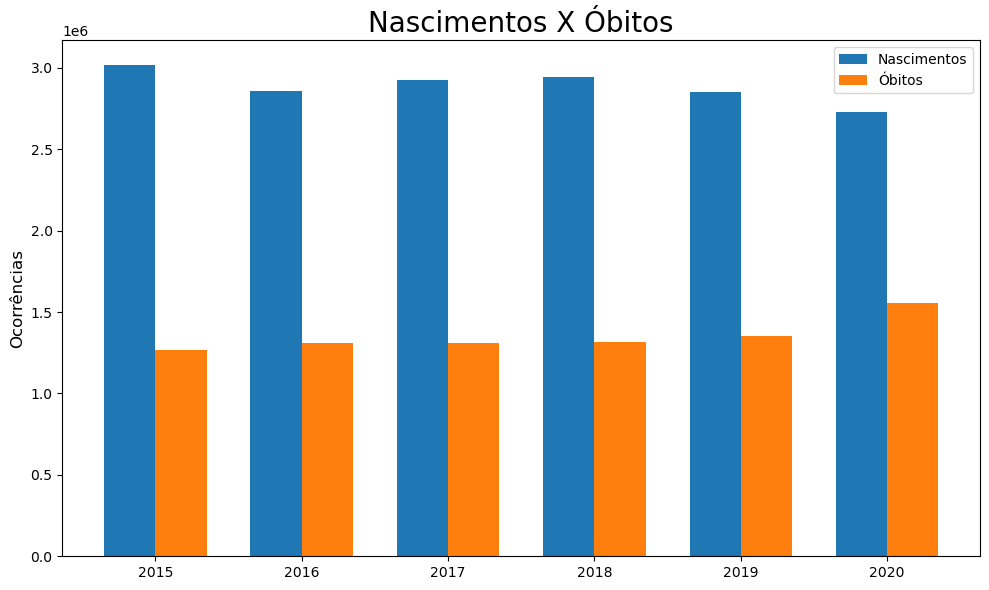

In [91]:
# Gráfico de barras: Ocorrências de Nascimentos x Óbitos por Ano
plt.rc('figure', figsize=(10, 6))
x = np.arange(len(anos))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x - width/2, total_nasc, width, label='Nascimentos')
ax.bar(x + width/2, total_obt, width, label='Óbitos')
ax.set_ylabel('Ocorrências', {'fontsize': 12})
ax.set_title('Nascimentos X Óbitos', {'fontsize': 20})
ax.set_xticks(x, anos)
ax.legend()
fig.tight_layout()
plt.show()

In [93]:
# Verificar os índices presentes no DataFrame
print(obitos.index)


Index(['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI',
       'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII', 'XVIII', 'XX', 'Total'],
      dtype='object')


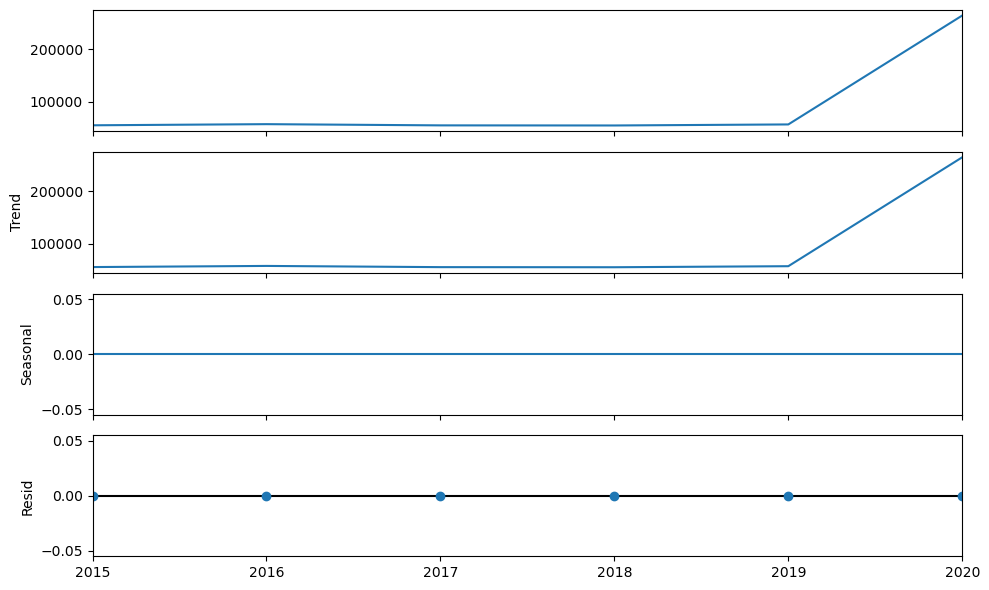

In [117]:
# Selecionando o CID 'I'
cid_especifico = obitos.loc['I']  # 'I' é um CID válido
cid_especifico = pd.Series(cid_especifico.values, index=anos)

# Decomposição da série temporal para análise de tendências e sazonalidades
result = seasonal_decompose(cid_especifico, model='additive', period=1)
result.plot()
plt.show()

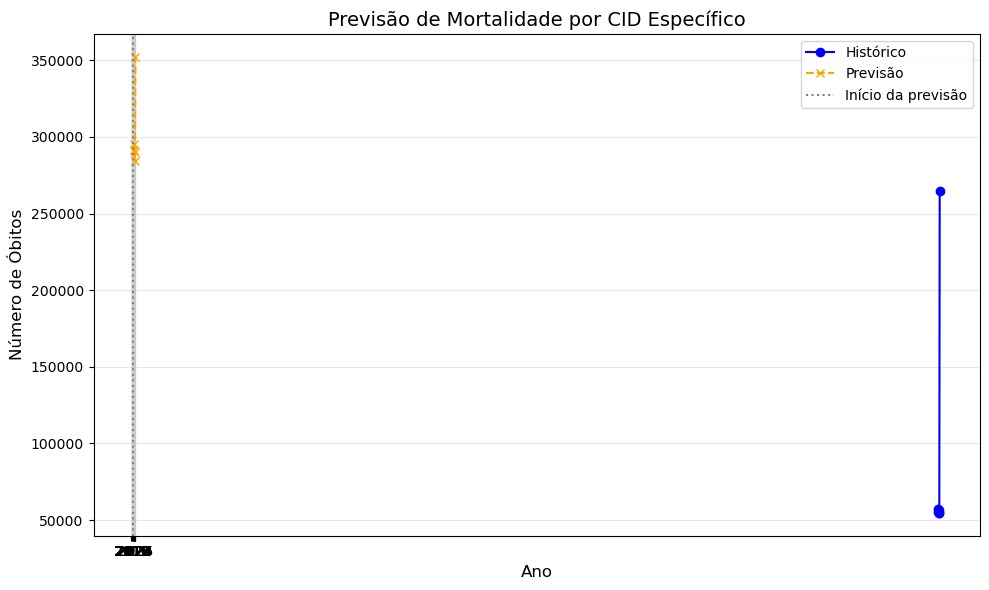

In [119]:
# Gerando a previsão
forecast = model_fit.forecast(steps=5)

# Criando os anos para a previsão
anos_previstos = np.arange(len(anos), len(anos) + 5)

# Gráfico melhorado
plt.figure(figsize=(10, 6))
plt.plot(anos, cid_especifico, label='Histórico', marker='o', color='blue')
plt.plot(anos_previstos, forecast, label='Previsão', linestyle='--', marker='x', color='orange')
plt.axvline(len(anos) - 1, color='gray', linestyle=':', label='Início da previsão')  # Divisão entre histórico e previsão
plt.title('Previsão de Mortalidade por CID Específico', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Número de Óbitos', fontsize=12)
plt.xticks(ticks=np.arange(0, len(anos) + 5), labels=list(anos) + list(range(anos[-1] + 1, anos[-1] + 6)))
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
